<a href="https://colab.research.google.com/github/reaganest/skin-disease-diagnosis/blob/Milestone-6/SuperPixel_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## to access the google drive with the google account
from google.colab import drive
drive.mount('/content/drive/')
from PIL import Image
import os
import torch
import torchvision
import cv2
import argparse
import numpy as np
import random
import skimage
import matplotlib.pyplot as plt
from torchvision.transforms import transforms as transforms
from skimage.color import rgb2gray
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage import io, segmentation
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.util import img_as_float
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel
from sklearn.cluster import KMeans
import torchvision.transforms.functional as F
from skimage.color import rgb2lab
import math

Mounted at /content/drive/


Subfolder: CD00001570
Image: CD00001570_20220325101331_0002_20220404172816_20220404_173657.jpg


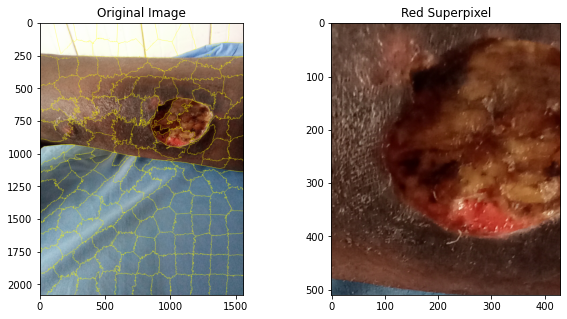

Image: CD00001570_20220325101331_0002_20220404172816_20220404_173617.jpg


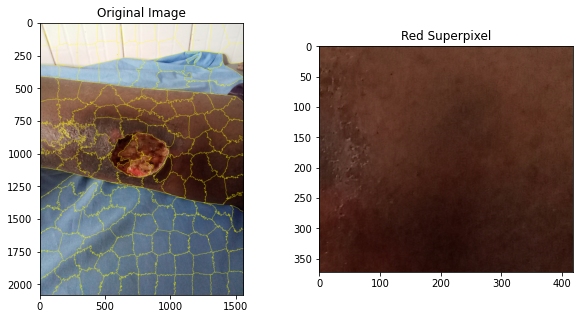

Image: CD00001570_20220325101331_0002_20220404172816_20220404_173641.jpg


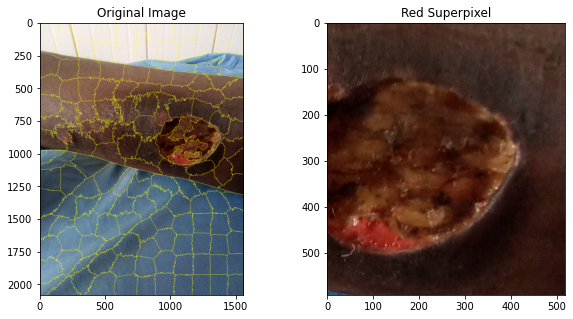

Image: CD00001570_20220325101331_0002_20220325102156_20220325_103142.jpg
No Red Superpixels Detected


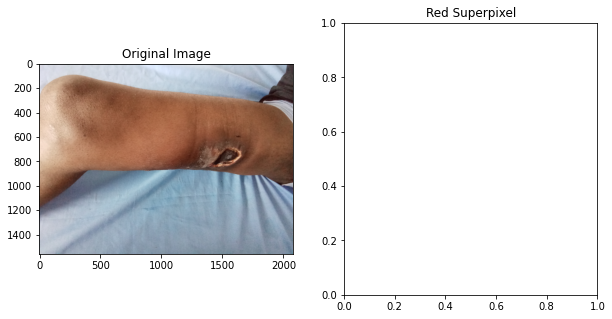

No Red Superpixels Detected
Image: CD00001570_20220325101331_0002_20220325102156_20220325_103123.jpg


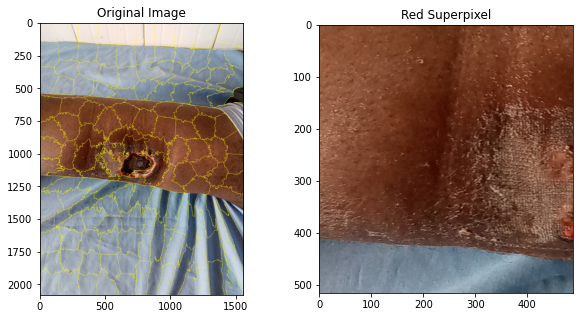

Image: CD00001570_20220325101331_0002_20220325102156_20220325_102936.jpg


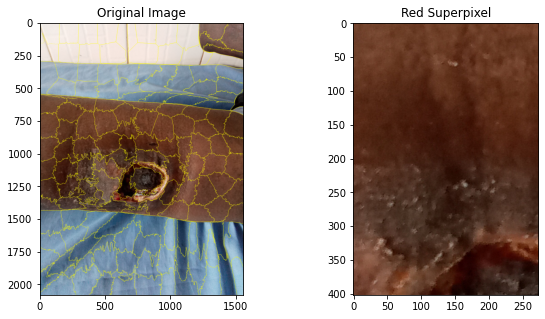

Image: CD00001570_20220325101331_0002_20220325102156_20220325_103059.jpg


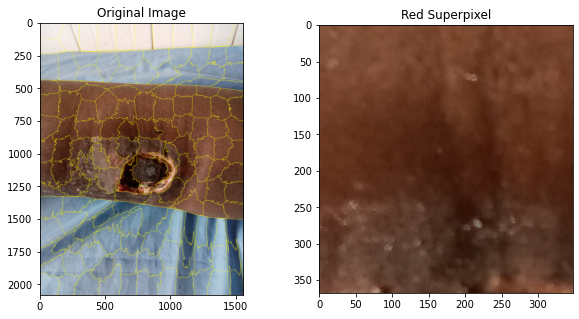

Image: CD00001570_20220325101331_0002_20220404172816_20220404_173441.jpg


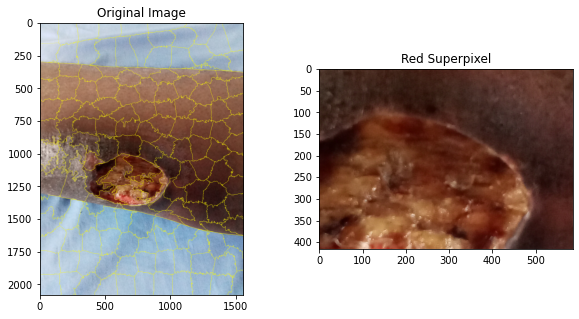

Subfolder: CD00001546
Image: CD00001546_20220919162249_0002_20220919162342_20220919_162823.jpg
No Red Superpixels Detected


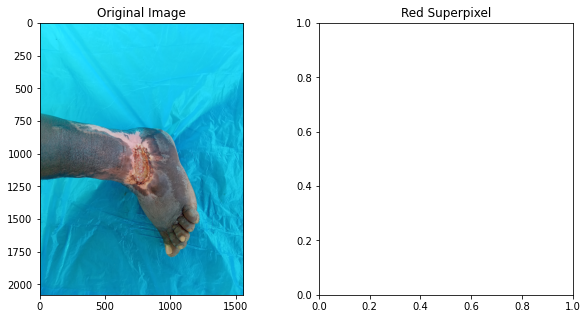

No Red Superpixels Detected
Image: CD00001546_20220919162249_0002_20220919162342_20220919_162726.jpg
No Red Superpixels Detected


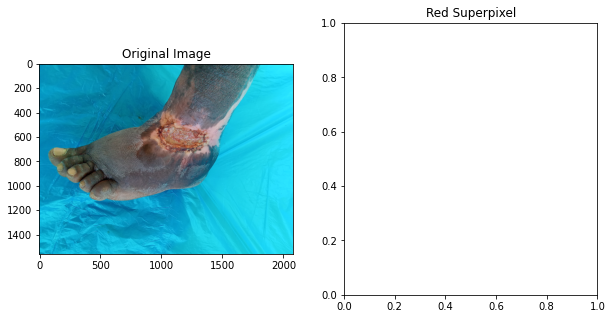

No Red Superpixels Detected
Image: CD00001546_20220919162249_0002_20220919162342_20220919_162842.jpg
No Red Superpixels Detected


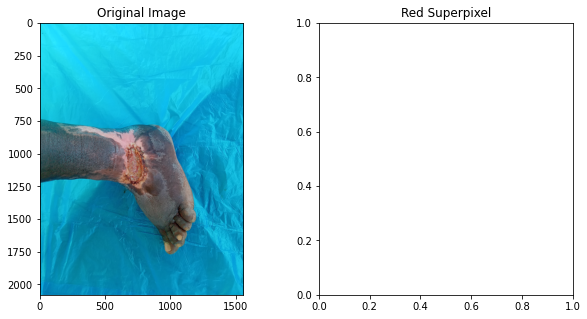

No Red Superpixels Detected
Subfolder: CD00001584
Image: CD00001584_20220224123341_0002_20220224123610_20220224_124017.jpg


ValueError: ignored

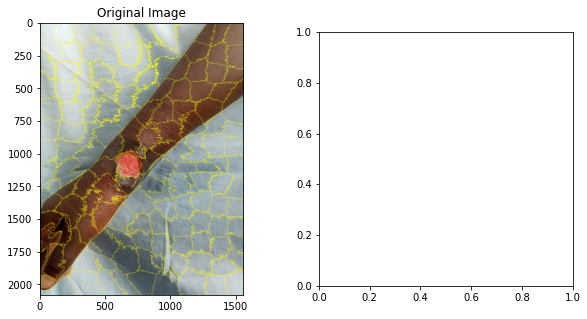

In [12]:
images = 'CD00001540_20220318082334_0002_20220318082450_20220318_082455.jpg'

folder = images[0:10]
image_path = '/content/drive/MyDrive/ColabNotebooks/SkinSegmentation/BU Raw Images/' + folder + '/' + images + ''

def get_superpixels(image_path):
    """
    Perform SLIC superpixel segmentation on the input image.

    Args:
    - image_path: string, the path to the input image.

    Returns:
    - segment_slic: numpy array, a 2D array containing the superpixel segment labels.
    """
    sk_image = io.imread(image_path)
    segment_slic = slic(sk_image, n_segments=150, compactness=10, sigma=1, start_label=0)
    return segment_slic


def get_red_superpixel(segment_slic, sk_image):
    """
    Find the superpixel with the most red pixels.

    Args:
    - segment_slic: numpy array, a 2D array containing the superpixel segment labels.
    - sk_image: numpy array, a 3D array containing the RGB pixel values of the input image.

    Returns:
    - red_mask: numpy array, a 2D boolean array containing True values where the red superpixel is located.
    """
    base_distance = 256
    red = 0
    label = 0
    found_red_superpixel = False  # add a flag to check if a red superpixel has been found
    for index in np.unique(segment_slic):
        superpixel = (segment_slic == index)
        average_superpixel_color = np.average(rgb2lab(sk_image[superpixel]), axis=0)
        lab_superpixel_color = rgb2lab([[average_superpixel_color]])
        avg_superpixel_red = np.clip(lab_superpixel_color, 0, 255, out=lab_superpixel_color)
        euclidean_distance = math.dist(avg_superpixel_red[0][0], [255, 0, 0])
        if euclidean_distance < base_distance:
            base_distance = euclidean_distance
            red = superpixel
            label = index
            found_red_superpixel = True
    if found_red_superpixel:  # if a red superpixel has been found
        red_id = np.where((np.unique(segment_slic)) == label)[0][0]
        red_mask = (segment_slic == red_id)
        return red_mask
    else:  # if no red superpixels have been found
        print('No Red Superpixels Detected')
        return None


def crop_red_superpixel(sk_image, red_mask):
    """
    Crop the input image to contain only the red superpixel.

    Args:
    - sk_image: numpy array, a 3D array containing the RGB pixel values of the input image.
    - red_mask: numpy array, a 2D boolean array containing True values where the red superpixel is located.

    Returns:
    - cropped: numpy array, a 3D array containing the RGB pixel values of the cropped image.
    """
    bbox = np.array([np.min(np.where(red_mask)[0]),
                     np.max(np.where(red_mask)[0]),
                     np.min(np.where(red_mask)[1]),
                     np.max(np.where(red_mask)[1])])
    middle = np.array([bbox[2] + (bbox[3] - bbox[2]) / 2, bbox[0] + (bbox[1] - bbox[0]) / 2])
    new_bbox = np.array([middle[0] - (bbox[3] - bbox[2]),
                         middle[0] + (bbox[3] - bbox[2]),
                         middle[1] - (bbox[1] - bbox[0]),
                         middle[1] + (bbox[1] - bbox[0])])
    final_bbox = np.round(new_bbox).astype(int)
    cropped = sk_image.copy()[final_bbox[2]:final_bbox[3], final_bbox[0]:final_bbox[1]]
    return cropped

def display(image_path):
    """
    Display the original input image and the cropped image containing the red superpixel.

    Args:
    - image_path: string, the path to the input image.
    """
    sk_image = io.imread(image_path)
    segment_slic = get_superpixels(image_path)
    red_mask = get_red_superpixel(segment_slic, sk_image)
    if red_mask is not None:
        cropped = crop_red_superpixel(sk_image, red_mask)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ax[0].imshow(mark_boundaries(sk_image, segment_slic))
        ax[0].set_title('Original Image')
        ax[1].imshow(cropped)
        ax[1].set_title('Red Superpixel')
        plt.show()
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ax[0].imshow(sk_image)
        ax[0].set_title('Original Image')
        ax[1].set_title('Red Superpixel')
        plt.show()
        print('No Red Superpixels Detected')
        
def display_folder(folder_path):
    """
    Display the original input image and the cropped image containing the red superpixel for each image in the input folder.

    Args:
    - folder_path: string, the path to the input folder.
    """
    for subfolder in os.listdir(folder_path):
        print(f'Subfolder: {subfolder}')
        subfolder_path = os.path.join(folder_path, subfolder)
        for image_name in os.listdir(subfolder_path):
            print(f'Image: {image_name}')
            image_path = os.path.join(subfolder_path, image_name)
            display(image_path)

display_folder('/content/drive/MyDrive/ColabNotebooks/SkinSegmentation/BU Raw Images/')